<a href="https://colab.research.google.com/github/thejarlid/makemore/blob/main/makemore_pt1/makemore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Data

In [ ]:
!wget https://raw.githubusercontent.com/karpathy/makemore/refs/heads/master/names.txt

--2025-07-10 18:48:14--  https://raw.githubusercontent.com/karpathy/makemore/refs/heads/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt.1’

names.txt.1         100%[===================>] 222.80K  --.-KB/s    in 0.02s   

2025-07-10 18:48:14 (13.8 MB/s) - ‘names.txt.1’ saved [228145/228145]



In [ ]:
!ls

names.txt  names.txt.1	sample_data


In [ ]:
words = open('names.txt', 'r').read().splitlines()

# Method 1: Bigram

This approach uses a bigram which counts frequency of pairs of characters to predict one character following the next.

From a high level the approach looks like a matrix where the row is the first letter (the letter we have seen) and each element of the row is the probability of the character that is mapped to that index is seen.

In [ ]:
# now we are going to create a 2d array the rows will be the first character in the bigram and the columns will be the second character in the bigram and then the
# value at the index will be the frequency of that combination
# We create a matrix defaulted with a count of 1 to avoid 0 in the probabilies which will lead to NAN calculations if they haven't been seen

import torch

In [ ]:
N = torch.ones((27, 27), dtype=torch.int32)
N[0, 0] = 0

In [ ]:
# for fast indexing into the 2d array
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

Create a frequency matrix N which stores the counts of pairs of characters

In [ ]:
for w in words[:]:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    N[ix1, ix2] += 1

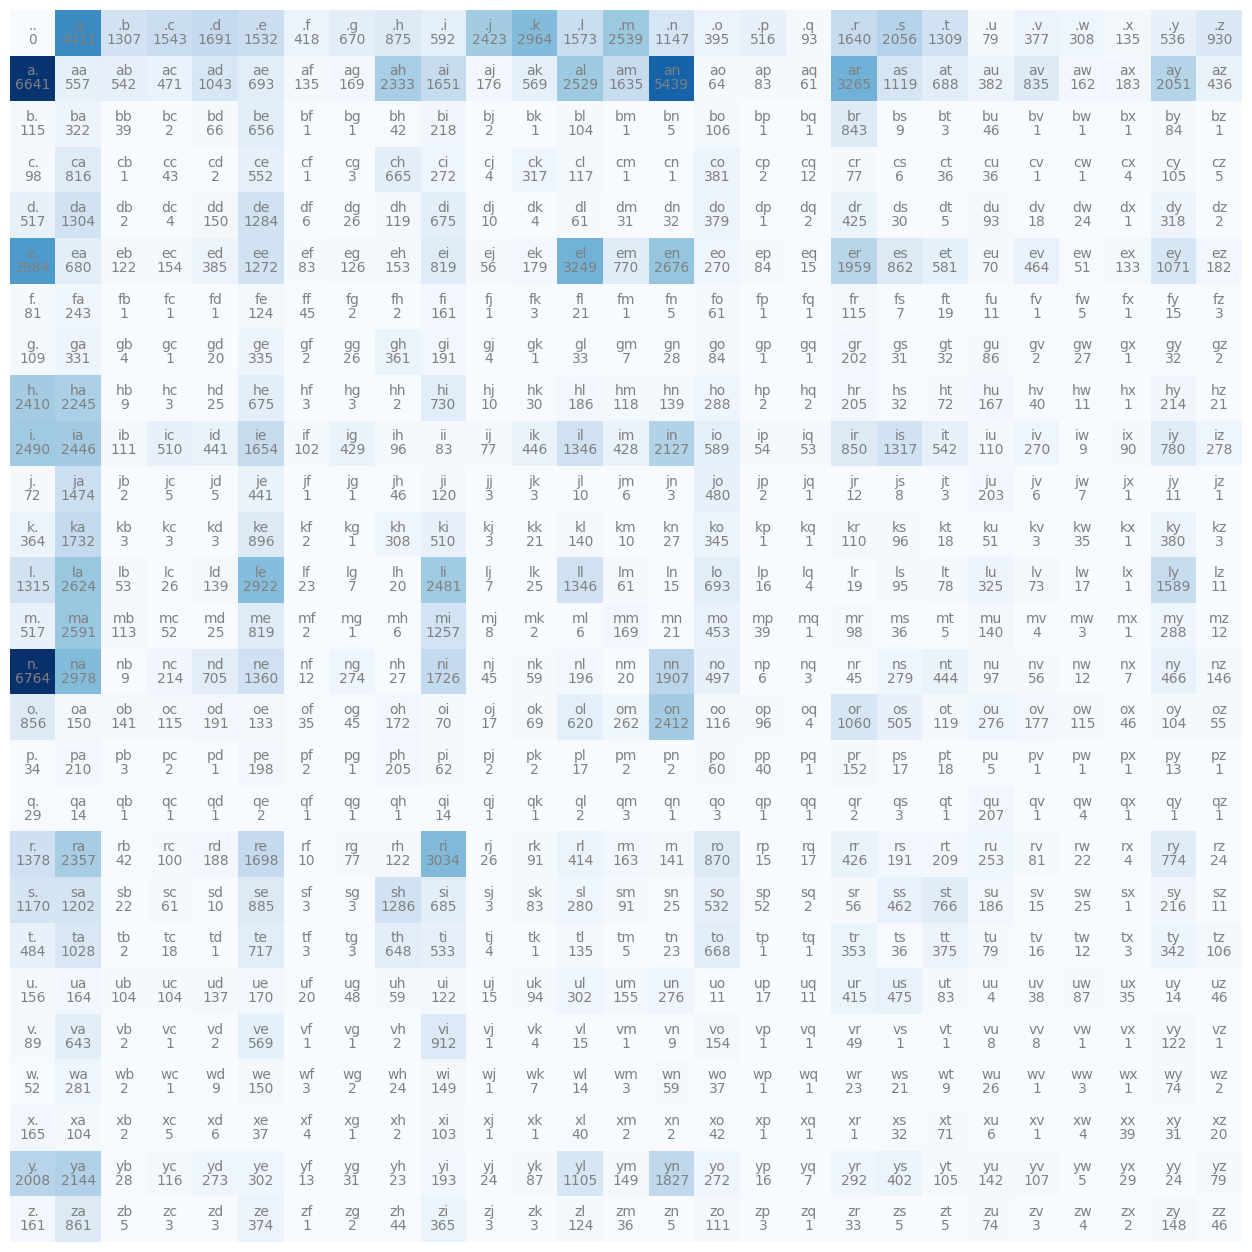

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')

for i in range(27):
  for j in range(27):
    chstr = itos[i] + itos[j]
    plt.text(j,i,chstr, ha="center", va="bottom", color="gray")
    plt.text(j,i,N[i,j].item(), ha="center", va="top", color="gray")
plt.axis('off');

# row is character to start a word
# column is character to end a word

From the frequency matrix now we create a probability matrix where we calculate the sum per row and then normalize N and store this in a new matrix P

In [ ]:
P = N / N.sum(1, keepdim=True)

## Loss Function

In [ ]:
# GOAL: maximize likelihood of the data wrt model params (statistical modeling)
# equivalent to maximizing the log likelihood (because log is monotonic)
# equivalent to minimizing the negative log likelihood
# equivalent to minimizing the average negative log likelihood

# log(a*b*c) = log(a) + log(b) + log(c)

In [ ]:
log_liklihood = 0.0
n = 0
for w in words[:]:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    prob = P[ix1, ix2]
    logprob = torch.log(prob)
    log_liklihood += logprob
    n += 1
print(f'{log_liklihood=}')
negative_log_liklihood = -log_liklihood
print(f'{negative_log_liklihood=}')
print(f'{negative_log_liklihood/n}')

log_liklihood=tensor(-559951.0625)
negative_log_liklihood=tensor(559951.0625)
2.4543540477752686


## Sampling

In [ ]:
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
  out = []
  ix = 0
  while True:
    p = P[ix]
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))

junide.
janasah.
p.
cony.
a.


# Method 2: Single Layer Neural Network (Perceptron)

In [ ]:
# -------------------- !!! OPTIMIZATION !!! -----------------------

In [ ]:
# create a training set of all the bigrams
xs, ys = [], []

for w in words[:]:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    xs.append(ix1)
    ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print('number of examples:', num)

# initialize the network
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27,27), generator=g, requires_grad=True)

number of examples: 228146


In [ ]:
import torch.nn.functional as F

# gradient descent
for k in range(200):
  # forward pass
  xenc = F.one_hot(xs, num_classes=27).float() # input to the network one-hot encoding
  logits = xenc @ W # predict log-counts
  counts = logits.exp() # coutns, equivalent to N
  probs = counts / counts.sum(1, keepdims=True) # probabiliites for next character
  # the last two lines here are together called a 'softmax'
  loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean() # adding regularization to the end of the loss as well which incentivises non 0 weights
  print(loss.item())

  # backward pass
  W.grad = None # set to zero gradient
  loss.backward()
  # update
  W.data += -50 * W.grad

3.7686190605163574
3.3788065910339355
3.16109037399292
3.0271859169006348
2.9344842433929443
2.867231607437134
2.8166542053222656
2.777146339416504
2.7452542781829834
2.7188303470611572
2.696505546569824
2.6773719787597656
2.6608052253723145
2.6463515758514404
2.633664846420288
2.622471570968628
2.6125476360321045
2.6037068367004395
2.595794916152954
2.5886809825897217
2.5822560787200928
2.5764293670654297
2.5711236000061035
2.5662729740142822
2.5618228912353516
2.5577263832092285
2.5539441108703613
2.550442695617676
2.5471925735473633
2.5441696643829346
2.5413522720336914
2.538722038269043
2.536262035369873
2.5339581966400146
2.531797409057617
2.529768228530884
2.527859926223755
2.5260636806488037
2.5243701934814453
2.522773265838623
2.52126407623291
2.519836902618408
2.5184857845306396
2.5172054767608643
2.515990734100342
2.5148372650146484
2.5137407779693604
2.512697696685791
2.511704921722412
2.5107581615448
2.509854555130005
2.5089924335479736
2.5081682205200195
2.507380485534668


In [ ]:
# finally, sample from the 'neural net' model
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
  out = []
  ix = 0
  while True:
    # --------
    # BEFORE:
    # p = P[ix]
    # --------
    # NOW:
    xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
    logits = xenc @ W # predict log-counts
    counts = logits.exp() # counts, equivalent to N
    p = counts / counts.sum(1, keepdims=True) # probabilities for next chatacter
    # --------

    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))

junide.
janasah.
prelay.
a.
nn.
